In [1]:
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import numpy as np
import pandas as pd
import sounddevice as sd
import helpers as hp
import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
import librosa
import librosa.feature
import imp 
import os, random
import warnings
from IPython.display import IFrame
from PIL import Image
import matplotlib.ticker as ticker
warnings.filterwarnings('ignore')

imp.reload(hp)
sr=48000

## Make Your Own Audience
#### Virtual Listeners Can Filter Generated Drum Programs
- Create sounds
- Curate datasets of drums (share it with others)
- Create a listeners that prefer drums
- Listeners judge sounds
- Keep sounds that are judged positively

In [2]:
IFrame("./presentation_data/pipeline.pdf", width=1200, height=500)

# Synthesizer, and Synthsizer Modules:
    - No Neural Nets
    - Built with:
        ~90% -> https://github.com/luvsound/pippi
        ~10% -> https://www.scipy.org/

In [3]:
IFrame("./presentation_data/synthesizer_all_blocks.pdf", width=1600, height=800) 

In [4]:
# Synthesizer Module Class
class Synth_Module():
    def __init__(self,params):
        buff=SoundBuffer(channels=1)
        length=1
        if params.isNoise==1:
            buff = noise.bln(params.getOscType(),params.getLength(),30,
                150000,channels=1) 
        else:
            buff = Osc(str(params.getOscType()), freq=list(params.getPitches()),
                       channels=1).play(params.getLength()) 

        buff=buff.adsr(a=params.A, d=params.D, s=params.S, r=params.R)
        bpfilter=params.getBandPass()
        buff.frames = helpers.butter_bandpass_filter(buff.frames,bpfilter[0],bpfilter[1], 
                                                     sr, order=bpfilter[2])
        buff.frames = helpers.butter_bandpass_filter(buff.frames,80,15000, 
                                                     sr, order=8)
        self.buff=buff

### Synthesizer Sub-Module Paramters:
| Parameters       | Value Range     | Notes and Constraints                            |
|------------------|-----------------|--------------------------------------------------|
| Attack           | 0\-3            | A\-D\-S\-R values relative                       |
| Decay            | 0\-3            | relative to A\-S\-R                              |
| Sustain          | 0\-3            | relative to A\-D\-R                              |
| Release          | 0\-3            | relative to A\-D\-S                              |
| OSC type         | sine,square,saw | \-                                               |
| IsNoise          | boolean         | generate noise using  cloud of waveform |
| Length           | 0\-1 second     | \-                                               |
| StartTime        | 0\-1 second     | Length\+Start$<$1                                |
| Amplitude        | 0\.1\-1         | 1 = max amplitude                                |
| Pitches\(notes\) | list of pitches | range of C0\(16\.35hz\) to B9                    |
| HP filter Cutoff | 0\-20000hz      | \-                                               |
| LP filter Cutoff | 20000hz\-HP     | never lower than HP cutoff                       |
| Filter Order     | 4,8,16          | butterworth filter order                         |

In [5]:
IFrame("./presentation_data/synthesizer_block.pdf", width=1500, height=320)

## Creating Sounds via Random Synth. Parameters

In [60]:
%%time
out = dsp.buffer(length = 1, channels = 1)
params = []; stack_num = 16; params = [pg.RandomParams() for i in range(stack_num)]
sound = pg.ensemble(params)
# hp.specShow(sound)
# for i, p in enumerate(params):
#     print("submodule %d Paramters:"%(i,))
#     print(p.__dict__)
# print("\n")
Audio(sound,rate = sr, autoplay = True)

CPU times: user 163 ms, sys: 234 µs, total: 163 ms
Wall time: 162 ms


## Mutation !!
    - For future work!

<Figure size 576x360 with 0 Axes>

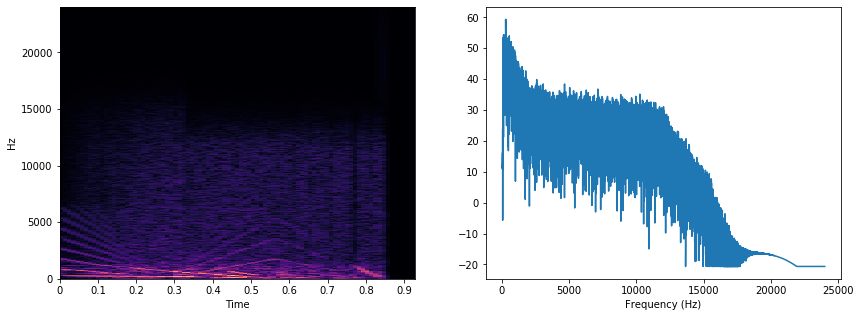

In [67]:
pm = [p.mutate(e=0.3, t=0.3) for p in params]
# for p in pm:
#     print(p.__dict__)
hp.specShow(pg.ensemble(params))
# Audio(pg.ensemble(pm),rate=sr, autoplay = True)

### So... we can make noise. What now?
- But how do we select ones that sound like drums?
- We need a virtual ear!
    - Decision 1: Recognizes drums from not-drums
    - Decision 2: Given a drum, it can categorize the type of drum

### Maybe these datasets can help
| DB Name   | Categories                                                     |
|-----------|----------------------------------------------------------------|
| FreeDB    | Kicks:533 \- Snares:372 \- Claps:230 \- Hats:105 \- Other:281  |
| RadarDB   | Kicks:1054 \- Snares:842 \- Claps:353              |
| MixedDB   | Kicks:533 \- Snares:372 \- Claps:230 \- Hats:105 \- Others:281 |
| NoiseDB | Generatable                                                    | 1 Stack:2000 3 Stacks:2000  5 Stacks:2000 |


### How do We Represent Sounds?

In [34]:
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from feature_extraction import pytorch_models as pm
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
from feature_extraction import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display

imp.reload(miru)
SR=44100
spec=torchaudio.functional.spectrogram
db_name="sample_swap_free_final"
drum_df=pd.concat([miru.audioFrames(db_name="radar",loadCache=True, path = "./feature_extraction/drum_dbs/"),
                   miru.audioFrames(db_name="sample_swap",path = "./feature_extraction/drum_dbs/",loadCache=True)])

loading data base from ./feature_extraction/drum_dbs/radar ./feature_extraction/drum_dbs/radar.dill
loading data base from ./feature_extraction/drum_dbs/sample_swap ./feature_extraction/drum_dbs/sample_swap.dill


In [35]:
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
        s= self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()
        freq=s
        freq[torch.isnan(freq)]=0
        freq=freq[0]
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

def MakeSpecs(tfList, plt):
    for i, tsfrm in enumerate(tfList):
        transformed_sample = tsfrm(sample)
        ax = plt.subplot(1, 3, i + 1)
        plt.tight_layout()
        ft=transformed_sample["feats"]
        if i==0:
            plt.title("Frequency Features",fontsize=20)
            plt.xlabel("Frequency Bin",fontsize=20)
            plt.ylabel("Scaled Magnitude",fontsize=20)
            plt.scatter(y=ft,x=range(0,len(ft)))
        if i==1:
            plt.title("Envelope Features",fontsize=20)
            plt.xlabel("Time Step",fontsize=20)
            plt.ylabel("Scaled Magnitude",fontsize=20)            
            plt.scatter(y=ft,x=range(0,len(ft)))
        if i==2:
            print(ft.shape,)
            sf=ft.detach().numpy()
            ft=ft.detach().numpy()
            plt.title("Spectrum Features",fontsize=20)
            librosa.display.specshow(sf,cmap='gray_r',)
            plt.xlabel("Time Step",fontsize=20)
            plt.ylabel("Magnitude of Bin",fontsize=20)


kick
torch.Size([40, 20])


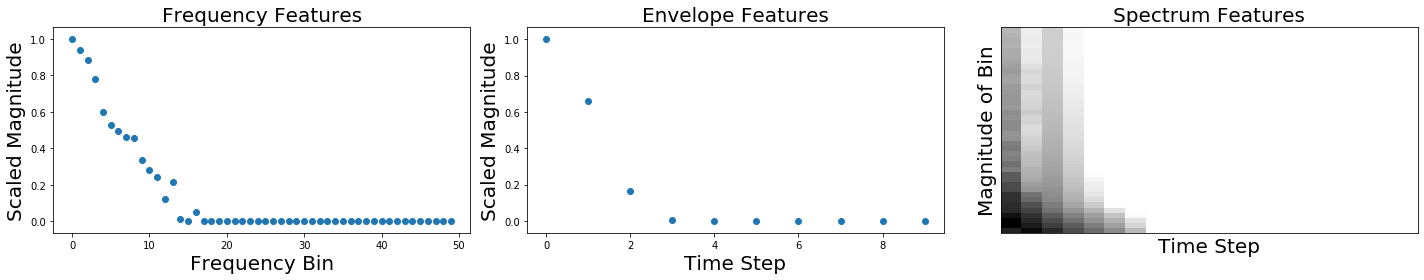

In [71]:
from feature_extraction import pytorch_models as pm
FREQ_BINS=40
TIME_STEPS=20
fig = plt.figure(figsize=(20,4))
ds=pm.audioDataset(pd.concat([drum_df],sort=False),"./",task="dvn",)
sample = ds[np.random.randint(len(drum_df))]
sample={"signal":sample["signal"],"label":sample["label"],"path":sample["path"],"drum_type":sample["drum_type"]}
print(sample["drum_type"])
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]
MakeSpecs(tfList, plt)
# Audio(sample["signal"],rate=SR,autoplay=True)

### Learning from these features:
- We Need a virtual ear to make quick decisions
    - Decision 1: Drum vs Not Drum
    - Decision 2: Different types of drums
    
- Major Hurdles:
    - Open Set Recognition
    - Training Time
    - Getting Data

### Model Types:
- Two Phased Ears
   - Decision 1, then Decision 2
- Mixed Ear Models:
    - Further condense the representation and make both decisions together

In [11]:
#TPE Ears
IFrame("./presentation_data/TPE_ear.pdf",width=1800, height=1000)

In [12]:
import sys
from joblib import dump, load
sys.path.append("..")
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import imp
from pathlib import Path

from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import param_generation as pg

import _pickle as pickle
from IPython.display import Audio
from feature_extraction.mir_utils import *

import torch.utils.data as utils
import torchvision.transforms as transforms
from PIL import Image
import common_vars as comv

import csv
import helpers
imp.reload(helpers)
imp.reload(comv)
imp.reload(pg)
from feature_extraction import pytorch_models as tm
from feature_extraction import pytorch_models as pm
imp.reload(tm)
from helpers import *

from common_vars import SR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path="./generated_sample_pack/"
# device = "cpu"
stack_size=3
BATCH_SIZE=1
NUM_BINS=100

classes=comv.classes
classes_ranked=comv.classes_ranked
cDict={v:i for i,v in enumerate(classes)}

drum_groups=['snare','kick','hat','other','clap']

drum_df=pd.DataFrame(columns=["name","fc","cnnlstm","env+freq","consensus","stack_size"])

def model_loader(m,p):
    s=torch.load(p) 
    m.load_state_dict(s)
    m.to(device)
    return m


imp.reload(pm)

input_dim = 120
seq_dim=100
output_size = 5
hidden_dim = 1000
n_layers = 1

    
#########DVN#########
#env model stuff
env_model_dvn = tm.env_Model(D_in=10,H1=10,H2=5,H3=10,H4=2,H5=10,device=device)
state='./feature_extraction/models/fc/env_dvn_95_35.pt'

env_model_dvn.load_state_dict(torch.load(state))
env_trans=tm.envTrans()
env_model_dvn.to(device)


# pitch model stuff
fc_spec_model_dvn=tm.getFCSpecModel(D_in=20*20,H1=20,H2=10,H3=4,D_out=2)
# state='./feature_extraction/models/fc/spec_fc_dvn_96.pt'
state='./feature_extraction/models/fc/final_spec_fc_dvn_97.pt'

fc_spec_model_dvn.load_state_dict(torch.load(state))
fc_spec_trans_dvn=tm.specTrans(20)
fc_spec_model_dvn.to(device)

#cnn lstm
cnn_model_dvn=pm.CNNLSTM_dvn()
# state='./feature_extraction/models/cnn/clst_dvn_96_279.pt'
state='./feature_extraction/models/cnn/final_clst_dvn_98_401.pt'


cnn_model_dvn.load_state_dict(torch.load(state))
cnn_model_dvn.to(device)
cnn_model_dvn.to(device)
#########DVD#########
#fc dvd
dvd_fc=pm.getFCSpecModel(D_in=20*20,H1=100,H2=50,H3=100,D_out=len(drum_groups))
# state='./feature_extraction/models/fc/spec_fc_dvd_81.pt'
state='./feature_extraction/models/fc/final_spec_fc_dvd_76.pt'
dvd_fc.load_state_dict(torch.load(state))
dvd_fc.to(device)

#cnn_dvd
dvd_cnn=pm.CNN_dvd(len_out=len(drum_groups))
# state='./feature_extraction/models/cnn/clst_dvd_90_170.pt'
state='./feature_extraction/models/cnn/final_cslt_dvd_86_94.pt'
dvd_cnn.load_state_dict(torch.load(state))
dvd_cnn.to(device)

#freq+env model
freq_env_model_dvd = tm.env_freq_Model(D_in=60,H1=30,H2=10,H3=10,D_out=len(drum_groups))
# state='./feature_extraction/models/fc/freq_env_dvd_86_351.pt'
state='./feature_extraction/models/fc/final_freq_env_dvd_85_205.pt'
freq_env_model_dvd.load_state_dict(torch.load(state))
freq_env_trans=tm.freq_and_env_Trans(feat_mels=50,env_mels=1)
freq_env_model_dvd.to(device)



from IPython.display import Audio
import librosa.display

for g in drum_groups:
    Path(save_path+"/"+g).mkdir(parents=True, exist_ok=True)


imp.reload(pm)

input_dim = 120
seq_dim=100
output_size = 5
hidden_dim = 1000
n_layers = 1
from IPython.display import Audio
import librosa.display

for g in drum_groups:
    Path(save_path+"/"+g).mkdir(parents=True, exist_ok=True)

#making graphs of models

from torchsummary import summary
import imp as imp
out,params= stackMaker(stack_size)
a= memToAud(out)
transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
env_feats=env_trans.call(transform_input)["feats"].to(device)
freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
spec_flat=torch.flatten(pitch_feats, start_dim=1)

outputEnvFreq=freq_env_model_dvd(freq_feats)
outputCNNDVD=dvd_cnn(pitch_feats.reshape(-1,1,20,20))
outputFCDVD=dvd_fc(spec_flat)
outputE=env_model_dvn(env_feats)
outputSPECFC=fc_spec_model_dvn(spec_flat)
outputCNN= cnn_model_dvn(pitch_feats.reshape(-1,1,20,20))


# summary(freq_env_model_dvd,freq_feats.shape)

model,x=freq_env_model_dvd,freq_feats
model,x=dvd_cnn,pitch_feats.reshape(-1,1,20,20)
model,x=cnn_model_dvn,pitch_feats.reshape(-1,1,20,20)
model,x=cnn_model_dvn,pitch_feats.reshape(-1,1,20,20)



def evalSoundSlow(a,env_thresh=0.5,fc_spec_tresh=0.5):
    try:
        a=librosa.util.normalize(a)
    except:
        pass
    transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
    env_feats=env_trans.call(transform_input)["feats"].to(device)
    freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
    pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
    spec_flat=torch.flatten(pitch_feats, start_dim=1)

    outputEnvFreq=freq_env_model_dvd(freq_feats)
    outputCNNDVD=dvd_cnn(pitch_feats.reshape(-1,1,20,20))
    outputFCDVD=dvd_fc(spec_flat)
    outputE=env_model_dvn(env_feats)
    outputSPECFC=fc_spec_model_dvn(spec_flat)
    outputCNN= cnn_model_dvn(pitch_feats.reshape(-1,1,20,20))
    
    o_e,o_fc_spec,o_cnn_spec=outputE[0].item(), outputSPECFC[0][0].item() ,outputCNN[0][0].item()
    tote=outputE[0].item()+outputSPECFC[0][0].item()

    gfc=drum_groups[torch.argmax(outputFCDVD).item()]
    gcnn=drum_groups[torch.argmax(outputCNNDVD).item()]
    genvfreq=drum_groups[torch.argmax(outputEnvFreq).item()]
    cat_consensus=drum_groups[torch.argmax(outputFCDVD+outputCNNDVD+outputEnvFreq)]
    
    spec_score=(o_fc_spec+o_cnn_spec)/2
    if (o_e>=env_thresh) or (o_cnn_spec<fc_spec_tresh) or o_fc_spec<fc_spec_tresh:
        print('\033[94m' + 'Decision 1:')
        print("env model ->",o_e)
        print("fc model ->",1 - o_fc_spec)
        print("CNN model -> ",1 - o_cnn_spec)
        print("Decision 2:")
        print("fc category ->",gfc,"\ncnn category ->",gcnn,"\nenv+freq->",genvfreq)
        
        return(a,env_feats,freq_feats,pitch_feats,stack_size,"found")
    return (a,env_feats,freq_feats,pitch_feats,stack_size,"not_found")

def findDrum(stack_size=1,iteration=0):
    out,params = stackMaker(stack_size)
    a = memToAud(out)
    return evalSoundSlow(a,env_thresh=0.5, fc_spec_tresh=0.5)
def tpe_run():
    i,j = 0,0
    while i<1000:
        i, j = i+1,j+1
        stack_size=np.random.choice([2])
        (a,env_feats,freq_feats,pitch_feats,stack_size,results)=findDrum(stack_size,iteration=i)
        if results!="not_found":
            print("\nit took %d iteration(s), stack size %d"%(j,stack_size))
            break
        print(i, end="\r")
    fig = plt.figure(figsize=(15,3))
    ax = plt.subplot(1, 2,1)
    plt.plot(env_feats.cpu())
    ax = plt.subplot(1,2,2)
    ft = pitch_feats.cpu()
    ft = ft.numpy()
    librosa.display.specshow(ft[0])
    return a
   

Decision 1:
env model -> 0.9648818969726562
fc model -> 0.00011146068572998047
CNN model ->  0.0002422928810119629
Decision 2:
fc category -> hat 
cnn category -> other 
env+freq-> clap

it took 133 iteration(s), stack size 3


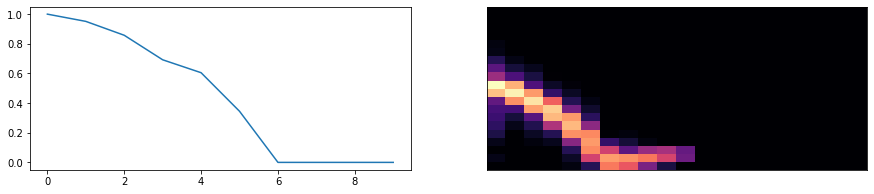

In [73]:
a = tpe_run()
Audio(a,rate=sr, autoplay=True)

More Examples:

Decision 1:
env model -> 1.6220045040427067e-07
fc model -> 0.439758837223053
CNN model ->  0.9371882304549217
Decision 2:
fc category -> hat 
cnn category -> clap 
env+freq-> clap

it took 112 iteration(s), stack size 3


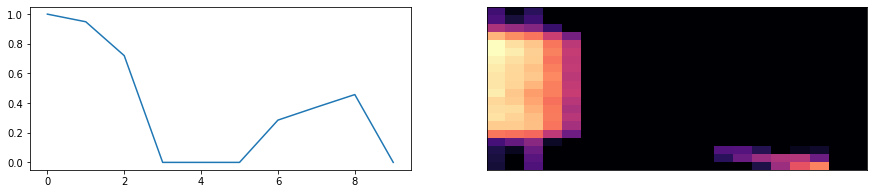

In [74]:
a = tpe_run()
# Audio(a,rate=sr, autoplay=False)

In [75]:
# a = tpe_run()
# Audio(a,rate=sr, autoplay=False)

Decision 1:
env model -> 0.9914578795433044
fc model -> 0.004564940929412842
CNN model ->  0.0002529025077819824
Decision 2:
fc category -> hat 
cnn category -> hat 
env+freq-> snare

it took 61 iteration(s), stack size 3


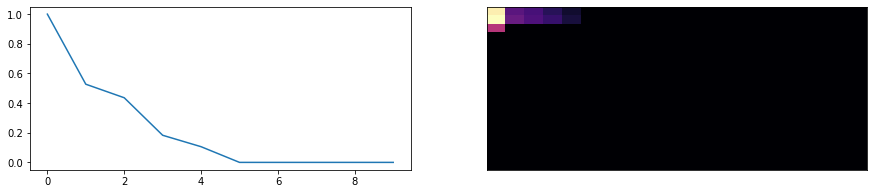

In [16]:
# a = tpe_run()
# Audio(a,rate=sr, autoplay=False)

Decision 1:
env model -> 0.8915913105010986
fc model -> 0.6594774425029755
CNN model ->  0.9369648396968842
Decision 2:
fc category -> snare 
cnn category -> other 
env+freq-> snare

it took 99 iteration(s), stack size 3


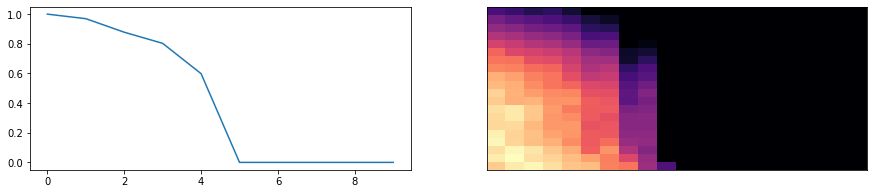

In [17]:
a = tpe_run()
Audio(a,rate=sr, autoplay=False)

In [18]:
# Survey distribution for TPE pipeline
IFrame("./structural_notebooks/cat_2p.pdf", width=1000, height=500)

### Fleiss Kappa Coefficients for  TPE Survey
| Drop Rule                           | Size | HvH   | H\+FC | H\+CNN | H\+E/F | 3 models |
|-------------------------------------|------|-------|-------|--------|--------|----------|
| No Drops                            | 257  | 0\.37 | 0\.35 | 0\.36  | 0\.36  | 0\.28    |
| Assigned "Bad" By Both              | 236  | 0\.31 | 0\.37 | 0\.37  | 0\.38  | 0\.30    |
| Assigned "Bad" By Either            | 180  | 0\.47 | 0\.50 | 0\.48  | 0\.48  | 0\.34    |
| Assigned "Bad" or "Other" By Either | 154  | 0\.47 | 0\.59 | 0\.54  | 0\.50  | 0\.35    |


In [19]:
# MEM Models
IFrame("./presentation_data/MEM_ear.pdf", width=1800, height=600)

In [20]:
# Running encoding and decoding recursively
IFrame("./presentation_data/Drums_reacreation.pdf", width=1800, height=600)

In [21]:
# interactive plot to check DVN results
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from plotly.subplots import make_subplots
import pandas as pd
import time
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding
import plotly.express as px
import plotly.graph_objs as go
import ipywidgets as widgets
import os
from sklearn import preprocessing
from ast import literal_eval
import io
from PIL import Image
import librosa
import sys
sys.path.append("..")
import torch
from feature_extraction import pytorch_utils as pu
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
from torch.utils.data import Dataset, DataLoader

min_max_scaler = preprocessing.MinMaxScaler()
n_neighbors = 10
FREQ_BINS=30
TIME_STEPS=20
SR=44100

def plotly_able_df(df,num_d=2):
    
    df["feats"]=df["feats"].apply(literal_eval)
    X=df["feats"]
    #convert series of arrays into a numpy array
    X=pd.DataFrame(X.to_list()).to_numpy()
    X = min_max_scaler.fit_transform(X)
    time_start = time.time()
#     tsne = TSNE(n_components=num_d, random_state=0, perplexity=100, verbose=1)
#     tsne = Isomap(n_neighbors, n_components=num_d)
#     tsne = LocallyLinearEmbedding(n_neighbors,n_components=num_d)
    tsne = SpectralEmbedding(n_neighbors=10,n_components=num_d,random_state=1)
    X_2d = tsne.fit_transform(X)
    
    if num_d==2:
        df2=pd.concat([df["path"],df["label"],df["drum_type"],pd.Series(X_2d[:,0]),pd.Series(X_2d[:,1])],axis=1)
        df2.columns=["path","label","drum_type","D1","D2"]
    if num_d==3:
        df2=pd.concat([df["path"],df["label"],df["drum_type"],pd.Series(X_2d[:,0]),pd.Series(X_2d[:,1]),pd.Series(X_2d[:,2])],axis=1)
        df2.columns=["path","label","drum_type","D1","D2","D3"]
    
    df2.label = df2.label.astype('str')
    return df2

class interactive_graph():
    def hover_fn(self,trace, points, state):
        if points.point_inds:
            ind = points.point_inds[0]
            drmName=trace.customdata[ind][0][:]
            filename=os.getcwd()+"/"+drmName
            with open(filename,'rb') as f:
                audio_data = f.read()
            self.aud.value=audio_data
            self.hover_data.value = str(drmName)+"\n"
            self.audioImg.value=self.audDisplay(filename)
            
    def audDisplay(self,f):
        #this got annoying because widget only accepts byte version of images
        audio_array=librosa.load(f)
        signals=audio_array[0]
        nz=np.max((SR-signals.shape[0],0))
        signals=np.concatenate([signals[0:SR],np.zeros(nz)]).astype("float32")

        sound={"signal":torch.tensor(signals),"label":'',"path":'',"drum_type":''}
        trns=pu.specTrans(FREQ_BINS,time_steps=TIME_STEPS)
        ft=trns(sound)["feats"]
        sf=ft.detach().numpy()[0]
        #flip upside down
        sf=sf[-1:0:-1][:]
        x=plt.imshow(sf)
        #convert to bytes so can be set to widget data
        buf = io.BytesIO()
        x.figure.savefig(buf, format='png')
        buf.seek(0)
        bufD=buf.getvalue()
        buf.close()
        
        return bufD
    def __init__(self,df,grouping_by="label",title="",num_d=2,sym_size=30,color=px.colors.qualitative.Vivid):
        if num_d==2:
            p = px.scatter(df, x="D1",y="D2",symbol="drum_type",color=grouping_by,hover_data=["path"],color_discrete_sequence=color)
        elif num_d==3:
            p = px.scatter_3d(df, x="D1",y="D2",z="D3",color=grouping_by,hover_data=["path"],symbol="label",color_discrete_sequence=color)
        for trace in p.data:
            trace.update(hoverinfo="none",hovertemplate= '')
        p.update_traces(marker=dict(size=sym_size,
                              line=dict(width=0,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

        self.hover_data = widgets.Textarea()  
        #audio and img widgets
        self.aud=widgets.Audio(autoplay=True,loop=False,embedding=False)
        self.audioImg=widgets.Image(
            value=b'',
            format='png',
            width='30%', 
        )
        #####
        layout = go.Layout(hovermode=False,)
        self.fig  = go.FigureWidget(p)
        self.fig.update_layout(scene = dict(
                    camera=dict(eye=dict(x=-1, y=-1, z=0)),
                    aspectmode="cube",),
                    margin=dict( r=0, l=0, b=0, t=0))
                    
        for f in self.fig.data:
            f.on_hover(self.hover_fn)        


In [22]:
# df = pd.read_csv("feature_extraction/csvs/r3_embeddings.csv")
# df["path"] = "feature_extraction/"+df["path"]

# df_2d=plotly_able_df(df,num_d=2,)
# df_2d_presentation = pd.concat([df_2d[df_2d["label"]=="0"].sample(frac=0.1),df_3d[df_3d["label"]=="1"].sample(frac=0.3)])
# df_2d_presentation.to_csv("feature_extraction/csvs/presentation_2d_tsne")


In [23]:
#make fresh or load from frozen
# df_2d = pd.read_csv("feature_extraction/csvs/presentation_2d_tsne")
# df_2d_presentation = pd.concat([df_2d[df_2d["label"]==0].sample(frac=0.25),
#            df_2d[df_2d["label"]==1].sample(frac=0.3)])

# if loading from frozen
df_2d_presentation = pd.read_csv("feature_extraction/csvs/frozen_2d_tsne.csv")

In [24]:
ig=interactive_graph(df_2d_presentation,grouping_by="drum_type",
                     title="64 dim embedding",num_d=2,sym_size=10, 
                     color=px.colors.qualitative.G10_r,)
 
display(ig.fig,widgets.HBox([ig.hover_data,ig.audioImg,ig.aud,]))

FigureWidget({
    'data': [{'customdata': array([['feature_extraction/./drum_dbs/radar/kick/B_Kick_01.wav'],
…

In [25]:
# if you like the graph
# df_2d_presentation.to_csv("feature_extraction/csvs/frozen_2d_tsne.csv")

### Training with Embeddings
- 2D projection indicates that the embeddings can be used for classification.
- We compare the classification accuracy of a number of models trained with embeddings+envelope features

In [26]:
def mme_comparisons():
    comparison_csv_file="feature_extraction/csvs/mme_comparisons_mme.csv"
    df=pd.read_csv(comparison_csv_file)
    fig = px.box(df, x="model", y="y", color="feat_type",
                 color_discrete_sequence=["#00AA77","#3388BB"],
                 title="Box plot of total bill",
                )
    fig.update_layout(
        autosize=False,title=None, 
        template="seaborn",
        width=1000,height=500,
        font_family="Times New Roman",
        font_size=18,
        title_font_family="Times New Roman",
        title_font_size=30, 
        boxmode='group',
        margin=dict(l=0, t=1,r=5, b=3),       
        boxgap=0.4,boxgroupgap=0.4,
            legend_title_text="Feature Type:",
                      legend=dict(
                          bgcolor='rgba(110,150,160,0.1)',
                      orientation="h",
                    yanchor="top",
                    y=1,
                    xanchor="right",x=1)
        )
    fig.update_traces(
            boxmean="sd", # represent mean. (sd shows standarddev)
            boxpoints='all', 
    )
    fig.update_xaxes(showgrid=False,zeroline=False,ticks='',title=None)
    fig.update_yaxes(showgrid=False,zeroline=False,title="Validation F-Scores")

    return fig

In [37]:
fig = mme_comparisons()
fig.show()

In [39]:

IFrame("./structural_notebooks/cat_mme.pdf", width=1500, height=400)

| Drop Rule                           | Size | HvH    | H\+MME |
|-------------------------------------|------|--------|--------|
| No Drop                             | 300  | 0\.336 | 0\.250 |
| Assigned "Bad" By Both              | 249  | 0\.200 | 0\.260 |
| Assigned "Bad" By Either            | 151  | 0\.460 | 0\.473 |
| Assigned "Bad" or "Other" By Either | 120  | 0\.620 | 0\.587 |


### Conclusion 
- We implemented a virtual synthesizer and virtual ears
- We made them work together to create drum sounds
- Computational overhead is fairly small
    - Sound generation is quick
    - Models are small and train quickly
- Both approaches produce drum samples but...

### Future Work (Collaborations Welcome!)
1. There are a lot of "duds" mixed in, possible causes:
    - Open set recognition 
    - Better models
    - Need to learn quicker with less data
2. A lot of the produced samples sound the same. 
    - Need more powerful synthesizers
    - Need

#### Questions?

In [29]:
IFrame("./presentation_data/conclusion.pdf", width=1800, height=1000)